<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
from __future__ import print_function
from __future__ import absolute_import

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Differentiation

**GOAL:**  Given a set of $N+1$ points $(x_i, y_i)$ compute the derivative of a given order to a specified accuracy.

**Approach:** Find the interpolating polynomial $P_N(x)$ and differentiate that.

### Newton Polynomials

While the interpolating polynomial $P_N(x)$ through $N+1$ distinct points is unique,  it can be expressed in terms of many bases.

So far we have considered the monomial basis $< 1,x,x^2,\ldots,x^n>$ and the Lagrange basis $\ell_i(x)$

However, for our purposes here it's somewhat more convenient to use the *Newton Polynomial* Basis

\begin{align}
    n_0 &= 1\\
    n_j(x) &= \prod^{j-1}_{i=0} (x - x_i)\quad\mathrm{for}\quad j>0 \\
\end{align}


### Newton Polynomials

Unrolling them, we see
\begin{align}
    n_0(x) &= 1\\
    n_1(x) &= (x-x_0) \\
    n_2(x) &= (x - x_0)(x-x_1)\\
        &\vdots \\
    n_N(x) &= (x - x_0)(x - x_1)\cdots(x-x_{N-1})\\
\end{align}

Note:  The Newton polynomials have some features common to both the monomials and the Lagrange polynomials

* Like the monomials they are monic polynomials of increasing degree in $x$, i.e. $n_2(x)$ is quadratic
* Like the Lagrange polynomials, some Newton polynomials vanish identically at the interpolation points $x_i$.  In particular

$$
    n_j(x_i) = 0 \quad \mathrm{for}\quad j> i
$$

### Newton's Form

This last feature makes it convenient to solve for the interpolating polynomial.

$$P_N(x) = \sum^N_{j=0} a_j n_j(x)$$

as the $(N+1)\times (N+1)$ linear system

$$
    P_N(x_i) = y_i\quad\mathrm{for}\quad i=0,\ldots,N
$$

#### Becomes the lower triangular system

$$
\begin{bmatrix}
1 & 0 & 0 & \ldots & 0 \\
1 & (x_1-x_0) & 0 & \ldots & 0 \\
1 & (x_2-x_0) & (x_2-x_0)(x_2-x_1) & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots  \\
1 & n_1(x_n) & n_2(x_n) & \ldots & n_n(x_n) \\
\end{bmatrix}\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
\vdots \\
a_n \\
\end{bmatrix}=
\begin{bmatrix}
y_0 \\
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}
$$

Which can be solved sequentially starting with

\begin{align}
    a_0 & = y_0\\
    a_1 & = \frac{y_1 - y_0}{x_1 - x_0} \\
    a_2 & = \frac{y_2 - y_0 - a_1(x_2 - x_0)}{(x_2-x_0)(x_2-x_1)} \\
    &\vdots \\
\end{align}

### The divided differences

The $a_j = [y_0, \ldots, y_j]$ are also known as *the divided differences* which are defined recursively as

$$[y_i] = y_i \quad i \in \{0,\ldots, N+1\}$$

and

$$[y_i, \ldots , y_{i+j}] = \frac{[y_{i+1}, \ldots , y_{i + j}] - [y_{i},\ldots,y_{i+j-1}]}{x_{i+j} - x_{i}} \quad i \in \{0,\ldots,N+1 - j\} \quad j \in \{1,\ldots, N+1\}$$

These formulas are recursively defined but not so helpful, here are a few examples to start out with:

$$[y_0] = y_0$$

$$[y_0, y_1] = \frac{y_1 - y_0}{x_1 - x_0}$$

$$[y_0, y_1, y_2] = \frac{[y_1, y_2] - [y_0, y_1]}{x_{2} - x_{0}} = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0} = \frac{y_2 - y_1}{(x_2 - x_1)(x_2 - x_0)} - \frac{y_1 - y_0}{(x_1 - x_0)(x_2 - x_0)}$$

The benefit of writing a polynomial like this is that it isolates the $x$ dependence (we can easily take derivatives of this form).

In general then $P_N(x)$ can be written in Newton's form as

$$P_N(x) = y_0 + (x-x_0)[y_0, y_1] + (x - x_0) (x - x_1) [y_0, y_1, y_2] + \cdots + (x-x_0) (x-x_1) \cdots (x-x_{N-1}) [y_0, y_1, \ldots, y_{N}]$$

Coefficients of Newton form are the divided differences.

Note: Much simpler in Lagrange basis,

In [2]:
# Recursive function (calls itself until it gets to last iteration) (else-->if)
def divided_difference(x, y, N=50):
    """Compute the Nth divided difference using *x* and *y*"""
    if N == 0:
        raise Exception("Reached recursion limit!")
    
    # Reached the end of the recurssion
    if y.shape[0] == 1:
        return y[0]
    elif y.shape[0] == 2:
        return (y[1] - y[0]) / (x[1] - x[0])
    else:
        return (divided_difference(x[1:], y[1:], N=N-1) - divided_difference(x[:-1], y[:-1], N=N-1)) / (x[-1] - x[0])
    
def newton_basis(x, x0):
    """ construct newton basis for the interpolating polynomial given interpolation points x0"""
    basis = numpy.ones((len(x0), len(x)))
    for j in range(len(x0)):
        for i in range(j):
            basis[j, :] *= (x - x0[i])
    return basis

def P_newton(x, data):
    """ construct the interpolating polynomial of order N through the N+1 data points data using a Newton basis"""
    P = numpy.zeros(x.shape)
    basis = newton_basis(x, data[:,0])
    for j in range(data.shape[0]):
        P += divided_difference(data[:j + 1, 0], data[:j + 1, 1]) * basis[j, :]
        
    return P

In [3]:
# Calculate a polynomial in Newton Form
data = numpy.array([[-2.0, 1.0], [-1.5, -1.0], [-0.5, -3.0], [0.0, -2.0], [1.0, 3.0], [2.0, 1.0]])
x = numpy.linspace(-2.0, 2.0, 100)
basis = newton_basis(x, data[:,0])
P = P_newton(x, data)
N = data.shape[0] - 1

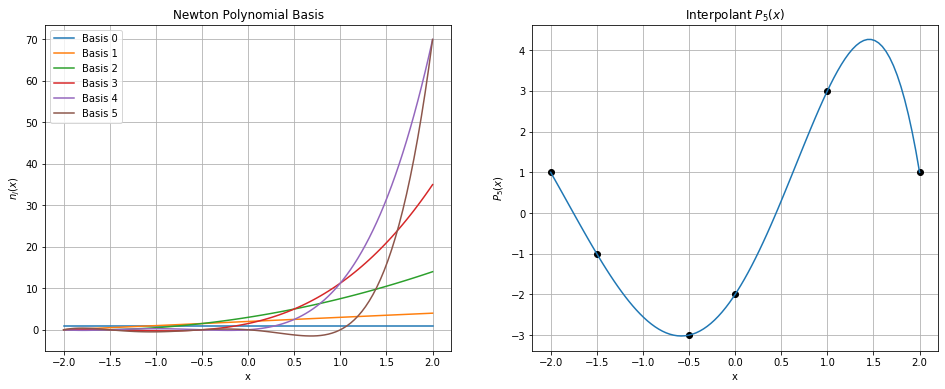

In [6]:
# Plot basis and interpolant
fig = plt.figure(figsize = (16,6))
fig.subplots_adjust(hspace=.5)

axes = [None, None]
axes[0] = fig.add_subplot(1, 2, 1)
axes[1] = fig.add_subplot(1, 2, 2)

for j in range(N + 1):
    axes[0].plot(x, basis[j, :], label='Basis {}'.format(j))
    axes[1].plot(data[j, 0], data[j, 1],'ko')
axes[1].plot(x, P)

axes[0].set_title("Newton Polynomial Basis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("$n_j(x)$")
axes[0].grid()
axes[0].legend()

axes[1].set_title("Interpolant $P_%s(x)$" % N)
axes[1].set_xlabel("x")
axes[1].set_ylabel("$P_%s(x)$" % N)
axes[1].grid()

plt.show()

As another concrete example consider the general quadratic polynomial written in Newton's form

$$P_2(x) = [y_0] + (x - x_0) [y_0, y_1] + (x - x_0)(x - x_1) [y_0, y_1, y_2] \\= y_0 + (x - x_0) \frac{y_1 - y_0}{x_1 - x_0} + (x - x_0)(x - x_1) \left ( \frac{y_2 - y_1}{(x_2 - x_1)(x_2 - x_0)} - \frac{y_1 - y_0}{(x_1 - x_0)(x_2 - x_0)} \right )$$

Recall that the interpolating polynomial of degree $N$ through these points is unique!

### Error Analysis

Given $N + 1$ points we can form an interpolant $P_N(x)$ of degree $N$ where

$$f(x) = P_N(x) + R_N(x)$$

And we know from Lagrange's Theorem that the remainder term looks like

$$R_N(x) = (x - x_0)(x - x_1)\cdots (x - x_{N})(x - x_{N+1}) \frac{f^{(N+1)}(c)}{(N+1)!}$$

noting that we need to require that $f(x) \in C^{N+1}$ on the interval of interest.  Taking the derivative of the interpolant $P_N(x)$ then leads to 

$$P_N'(x) = [y_0, y_1] + ((x - x_1) + (x - x_0)) [y_0, y_1, y_2] + \cdots + \left(\sum^{N-1}_{i=0}\left( \prod^{N-1}_{j=0,~j\neq i} (x - x_j) \right )\right ) [y_0, y_1, \ldots, y_N]$$

Similarly we can find the derivative of the remainder term $R_N(x)$ as

$$R_N'(x) = \left(\sum^{N}_{i=0} \left( \prod^{N}_{j=0,~j\neq i} (x - x_j) \right )\right ) \frac{f^{(N+1)}(c)}{(N+1)!}$$

Now if we consider the approximation of the derivative evaluated at one of our data points $(x_k, y_k)$ these expressions simplify such that

$$f'(x_k) = P_N'(x_k) + R_N'(x_k)$$

If we let $\Delta x = \max_i |x_k - x_i|$ we then know that the remainder term will be $\mathcal{O}(\Delta x^N)$ as $\Delta x \rightarrow 0$ thus showing that this approach converges and we can find arbitrarily high order approximations (ignoring floating point error).

### <font color='red'>Caution</font>

High order does not necessarily imply high-accuracy!

In [8]:
def PN_prime(x, data):
    """ calculate derivative of interpolating polynomail at point x"""
    # General form of derivative of P_N'(x)
    P_prime = numpy.zeros(x.shape)
    newton_basis_prime = numpy.empty(x.shape)
    product = numpy.empty(x.shape)
    N = data.shape[0] - 1
    for n in range(N + 1):
        newton_basis_prime = 0.0
        for i in range(n):
            product = 1.0
            for j in range(n):
                if j != i:
                    product *= (x - data[j, 0])
            newton_basis_prime += product
        P_prime += divided_difference(data[:n+1, 0], data[:n+1, 1]) * newton_basis_prime
        
    return P_prime

In [13]:
num_points = 4
xmin = -1.
xmax = 1.
data = numpy.empty((num_points, 2))
data[:, 0] = numpy.linspace(xmin, xmax, num_points)
data[:, 1] = numpy.sin(data[:, 0])
x = numpy.linspace(xmin, xmax, 100)
P_prime = PN_prime(x, data)

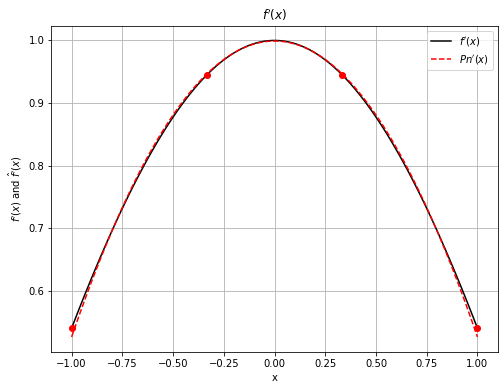

In [14]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, numpy.cos(x), 'k', label="$f'(x)$")
axes.plot(x, P_prime, 'r--', label="$Pn'(x)$")
axes.plot(data[:,0], numpy.cos(data[:,0]), 'ro')
axes.legend(loc='best')
axes.set_title("$f'(x)$")
axes.set_xlabel("x")
axes.set_ylabel("$f'(x)$ and $\hat{f}'(x)$")
axes.grid()

plt.show()

- H refinement: decrease $\Delta x$
- P refinement: increase polynomial order (number of points interpolated from)

### Examples

Often in practice we only use a small number of data points to derive a differentiation formula.  In the context of differential equations we also often have $f(x)$ so that $f(x_k) = y_k$ and we can approximate the derivative of a known function $f(x)$.

### Example 1:  1st order Forward and Backward Differences

Using 2 points we can get an approximation that is $\mathcal{O}(\Delta x)$:

$$f'(x) \approx P_1'(x) = [y_0, y_1] = \frac{y_1 - y_0}{x_1 - x_0} = \frac{y_1 - y_0}{\Delta x} = \frac{f(x_1) - f(x_0)}{\Delta x}$$

We can also calculate the error as

$$R_1'(x) = -\Delta x \frac{f''(c)}{2}$$

We can also derive the "forward" and "backward" formulas by considering the question slightly differently.  Say we want $f'(x_n)$, then the "forward" finite-difference ($x_{n+1} > x_n$) can be written as

$$f'(x_n) \approx D_1^+ = \frac{f(x_{n+1}) - f(x_n)}{\Delta x}$$

and the "backward" finite-difference ($x_{n-1} < x_n$) as

$$f'(x_n) \approx D_1^- = \frac{f(x_n) - f(x_{n-1})}{\Delta x}$$

Note these approximations should be familiar to use as the limit as $\Delta x \rightarrow 0$ these are no longer approximations but equivalent definitions of the derivative at $x_n$.

In [18]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 10
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute forward difference using a loop
f_prime_hat = numpy.empty(x_hat.shape)
for i in range(N - 1):
    f_prime_hat[i] = (f(x_hat[i+1]) - f(x_hat[i])) / delta_x
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x

# Vector based calculation (one line)
# f_prime_hat[:-1] = (f(x_hat[1:]) - f(x_hat[:-1])) / (delta_x)

# Use first-order differences for points at edge of domain
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x  # Backward Difference at x_N

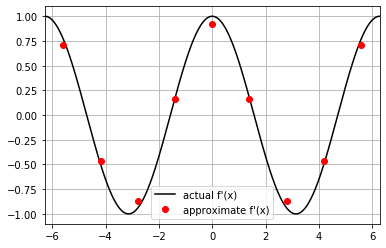

In [19]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_prime(x), 'k', label='actual f\'(x)')
axes.plot(x_hat + 0.5 * delta_x, f_prime_hat, 'ro', label='approximate f\'(x)')
axes.set_xlim((x[0], x[-1]))
axes.set_ylim((-1.1, 1.1))
axes.grid()
axes.legend()

plt.show()

- Errors are largest where slope of f(x) is steepest ($\left|f'(x)\right|$ is large)
- Error as vector of errors as each point: can compute overall error using sum of abs value ($L^1$ norm) or sum of squares ($L^2$ norm) or $L^\infty$ (max(error))

#### Aside:  Computing Order of Convergence

Say we had the error $E(\Delta x)$ and we wanted to make a statement about the rate of convergence (note we can replace $E$ here with the $R$ from above).  Then we can do the following:
$$\begin{aligned}
    E(\Delta x) &= C \Delta x^n \\
    \log E(\Delta x) &= \log C + n \log \Delta x
\end{aligned}$$

The slope of the line is $n$ when modeling the error like this!  We can also match the first point by solving for $C$:

$$
    C = e^{\log E(\Delta x) - n \log \Delta x}
$$

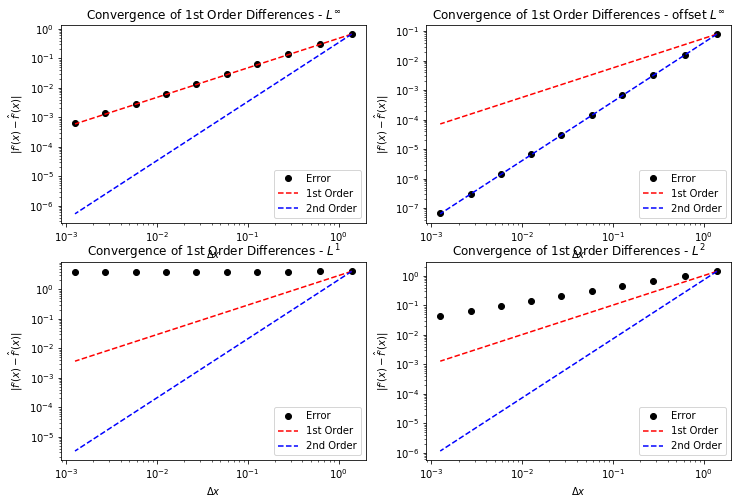

In [20]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Compute the error as a function of delta_x
N_range = numpy.logspace(1, 4, 10, dtype=int)
delta_x = numpy.empty(N_range.shape)
error = numpy.empty((N_range.shape[0], 4))
for (i, N) in enumerate(N_range):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
    delta_x[i] = x_hat[1] - x_hat[0]

    # Compute forward difference
    f_prime_hat = numpy.empty(x_hat.shape)
    f_prime_hat[:-1] = (f(x_hat[1:]) - f(x_hat[:-1])) / (delta_x[i])

    # Use first-order differences for points at edge of domain
    f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x[i]  # Backward Difference at x_N
    
    # The differences in error computations is interesting here.  Note that the L_\infty norm returns a single
    # point-wise like error where as the L_2 and L_1 are adding error up so they exhbit less convergence
    error[i, 0] = numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=numpy.infty)
    error[i, 1] = numpy.linalg.norm(numpy.abs(f_prime(x_hat + 0.5 * delta_x[i]) - f_prime_hat), ord=numpy.infty)
    error[i, 2] = numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=1)
    error[i, 3] = numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=2)
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
# plt.rc('legend', fontsize=6)
# plt.rc('font', size=6)

error_type = ['$L^\infty$', 'offset $L^\infty$', '$L^1$', '$L^2$']
for i in range(error.shape[1]):
    axes = fig.add_subplot(2, 2, i + 1)
    axes.loglog(delta_x, error[:, i], 'ko', label="Error")

    order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
    axes.loglog(delta_x, order_C(delta_x[0], error[0, i], 1.0) * delta_x**1.0, 'r--', label="1st Order")
    axes.loglog(delta_x, order_C(delta_x[0], error[0, i], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
    axes.legend(loc=4)
    axes.set_title("Convergence of 1st Order Differences - %s" % error_type[i])
    axes.set_xlabel("$\Delta x$")
    axes.set_ylabel("$|f'(x) - \hat{f}'(x)|$")

plt.show()

### Example 2: 2nd Order Centered Difference

Now lets use 3 points to calculate the 2nd order accurate finite-difference.  Consider the points $(x_{n}, y_{n})$, $(x_{n-1}, y_{n-1})$, and $(x_{n+1}, y_{n+1})$, from before we have

$$\begin{aligned}
    P_2(x) &= [f(x_0)] + (x - x_0) [f(x_0), f(x_1)] + (x - x_0)(x - x_1) [f(x_0), f(x_1), f(x_2)] \\
    &= f(x_0) + (x - x_0) \frac{f(x_1) - f(x_0)}{x_1 - x_0} + (x - x_0)(x - x_1) \left ( \frac{f(x_2) - f(x_1)}{(x_2 - x_1)(x_2 - x_0)} - \frac{f(x_1) - f(x_0)}{(x_1 - x_0)(x_2 - x_0)} \right )
\end{aligned}$$
Compute the formula for the derivative.  Assume that the distance between the $x_i$ are equal.

$$\begin{aligned}
    P_2'(x) &= [f(x_n), f(x_{n+1})] + ((x - x_n) + (x - x_{n+1})) [f(x_n), f(x_{n+1}), f(x_{n-1})] \\
    &= \frac{f(x_{n+1}) - f(x_n)}{x_{n+1} - x_n}  + ((x - x_n) + (x - x_{n+1}))\\ &* \left ( \frac{f(x_{n-1}) - f(x_{n+1})}{(x_{n-1} - x_{n+1})(x_{n-1} - x_n)} - \frac{f(x_{n+1}) - f(x_n)}{(x_{n+1} - x_n)(x_{n-1} - x_n)} \right )
\end{aligned}$$

Note: $x_{n-1} - x_{n+1} = 2\Delta x$ and $x_{n-1} - x_n = \Delta x$ and $x_{n+1} - x_n = \Delta x$

Evaluating at $x_n$ and assuming the points $x_{n-1}, x_n, x_{n+1}$ are evenly spaced leads to

$$\begin{aligned}
    P_2'(x_n) &= \frac{f(x_{n+1}) - f(x_n)}{\Delta x} - \Delta x \left ( \frac{f(x_{n-1}) - f(x_{n+1})}{2\Delta x^2} + \frac{f(x_{n+1}) - f(x_n)}{\Delta x^2} \right ) \\
    &=\frac{f(x_{n+1}) - f(x_n)}{\Delta x} - \left ( \frac{f(x_{n+1}) - 2f(x_n) + f(x_{n-1})}{2\Delta x}\right ) \\
    &=\frac{2f(x_{n+1}) - 2f(x_n) - f(x_{n+1}) + 2f(x_n) - f(x_{n-1})}{2 \Delta x} \\
    &=\frac{f(x_{n+1}) - f(x_{n-1})}{2 \Delta x}
\end{aligned}$$

This finite-difference is second order accurate and is centered about the point it is meant to approximate ($x_n$).  We can show that it is second order by again considering the remainder term's derivative

$$\begin{aligned}
    R_2'(x) &= \left(\sum^{2}_{i=0} \left( \prod^{2}_{j=0,~j\neq i} (x - x_j) \right )\right ) \frac{f'''(c)}{3!} \\
    &= \left ( (x - x_{n+1}) (x - x_{n-1}) + (x-x_n) (x-x_{n-1}) + (x-x_n)(x-x_{n+1}) \right ) \frac{f'''(c)}{3!}
\end{aligned}$$

Again evaluating this expression at $x = x_n$ and assuming evenly space points we have

$$R_2'(x_n) = -\Delta x^2 \frac{f'''(c)}{3!}$$

showing that our error is $\mathcal{O}(\Delta x^2)$.

In [24]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 11
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute derivative
f_prime_hat = numpy.empty(x_hat.shape)
f_prime_hat[1:-1] = (f(x_hat[2:]) - f(x_hat[:-2])) / (2. * delta_x)

# Use first-order differences for points at edge of domain
f_prime_hat[0] = (f(x_hat[1]) - f(x_hat[0])) / delta_x     # Forward Difference at x_0
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x  # Backward Difference at x_N
#f_prime_hat[0] = (-3.0 * f(x_hat[0]) + 4.0 * f(x_hat[1]) - f(x_hat[2])) / (2.0 * delta_x)
#f_prime_hat[-1] = (3.0 * f(x_hat[-1]) - 4.0 * f(x_hat[-2]) + f(x_hat[-3])) / (2.0 * delta_x)

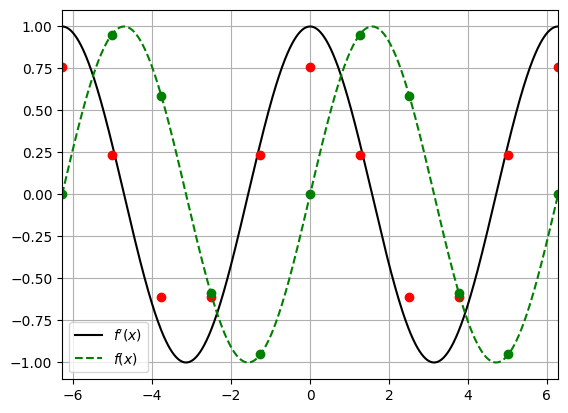

In [25]:
fig = plt.figure()
plt.rcdefaults()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_prime(x), 'k',label="$f'(x)$")
axes.plot(x_hat, f_prime_hat, 'ro')
axes.plot(x, f(x),'g--',label="$f(x)$")
axes.plot(x_hat, f(x_hat), 'go')
axes.set_xlim((x[0], x[-1]))
# axes.set_ylim((-1.1, 1.1))
axes.grid()
axes.legend()

plt.show()

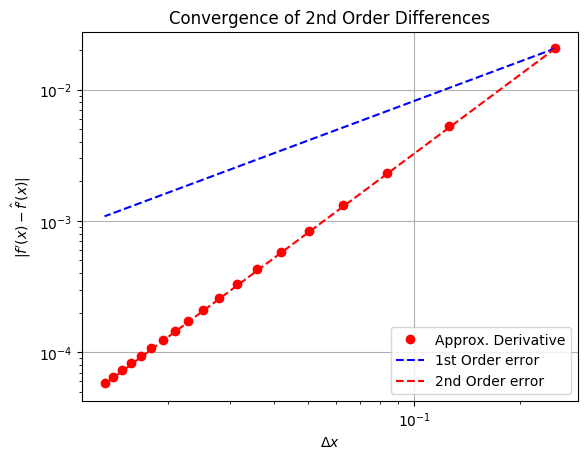

In [26]:
# Compute the error as a function of delta_x
delta_x = []
error = []
# for N in range(2, 101):
for N in range(50, 1000, 50):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N + 1)
    delta_x.append(x_hat[1] - x_hat[0])

    # Compute derivative
    f_prime_hat = numpy.empty(x_hat.shape)
    f_prime_hat[1:-1] = (f(x_hat[2:]) - f(x_hat[:-2])) / (2 * delta_x[-1])

    # Use first-order differences for points at edge of domain
    f_prime_hat[0] = (f(x_hat[1]) - f(x_hat[0])) / delta_x[-1]  
    f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x[-1]
    # Use second-order differences for points at edge of domain
    f_prime_hat[0] =  (-3.0 * f(x_hat[0])  +  4.0 * f(x_hat[1])  + - f(x_hat[2]))  / (2.0 * delta_x[-1])
    f_prime_hat[-1] = ( 3.0 * f(x_hat[-1]) + -4.0 * f(x_hat[-2]) +   f(x_hat[-3])) / (2.0 * delta_x[-1])
    
    # Compute Error
    error.append(numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=numpy.infty))
#     error.append(numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=2))
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error, "ro", label="Approx. Derivative")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'b--', label="1st Order error")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'r--', label="2nd Order error")
axes.legend(loc=4)
axes.set_title("Convergence of 2nd Order Differences")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|f'(x) - \hat{f}'(x)|$")
axes.grid()

plt.show()

### Example 3: Alternative Derivations

An alternative method for finding finite-difference formulas is by using Taylor series expansions about the point we want to approximate.  The Taylor series about $x_n$ is

$$f(x) = f(x_n) + (x - x_n) f'(x_n) + \frac{(x - x_n)^2}{2!} f''(x_n) + \frac{(x - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x - x_n)^4)$$

Note: slightly different error function

Say we want to derive the second order accurate, first derivative approximation that we just did, this requires the values $(x_{n+1}, f(x_{n+1})$ and $(x_{n-1}, f(x_{n-1})$.  We can express these values via our Taylor series approximation above as

\begin{aligned}
    f(x_{n+1}) &= f(x_n) + (x_{n+1} - x_n) f'(x_n) + \frac{(x_{n+1} - x_n)^2}{2!} f''(x_n) + \frac{(x_{n+1} - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x_{n+1} - x_n)^4) \\
\end{aligned}

or
\begin{aligned}
&= f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)
\end{aligned}

and

\begin{align}
f(x_{n-1}) &= f(x_n) + (x_{n-1} - x_n) f'(x_n) + \frac{(x_{n-1} - x_n)^2}{2!} f''(x_n) + \frac{(x_{n-1} - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x_{n-1} - x_n)^4) 
\end{align}

\begin{align} 
&= f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)
\end{align}

Or all together (__for regularly spaced points__),
\begin{align} 
f(x_{n+1}) &= f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)\\
f(x_{n-1})&= f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)
\end{align}

Now to find out how to combine these into an expression for the derivative we assume our approximation looks like

$$
    f'(x_n) + R'(x_n) = A f(x_{n+1}) + B f(x_n) + C f(x_{n-1})
$$

where $R(x_n)$ is our error.  

Plugging in the Taylor series approximations we find

$$\begin{aligned}
    f'(x_n) + R'(x_n) &= A \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)\right ) \\
    & + B f(x_n) \\ 
    & + C \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) \right )
\end{aligned}$$

__Method of undetermined coefficients__

Since we want $R(x_n) = \mathcal{O}(\Delta x^2)$ we want all terms lower than this to cancel __*except for those multiplying $f'(x_n)$ as those should sum to 1*__ {since we want to find $f'(x_n)$} to give us our approximation.  Collecting the terms with common evaluations of the derivatives on $f(x_n)$ we get a series of expressions for the coefficients $A$, $B$, and $C$ based on the fact we want an approximation to $f'(x_n)$.  The $n=0$ terms collected are $A + B + C$ and are set to 0 as we want the $f(x_n)$ term to also cancel.

$$\begin{aligned}
    f(x_n):&  &A + B + C &= 0 \\
    f'(x_n): & &A \Delta x - C \Delta x &= 1 \\
    f''(x_n): & &A \frac{\Delta x^2}{2} + C \frac{\Delta x^2}{2} &= 0
\end{aligned} $$

This last equation $\Rightarrow A = -C$, using this in the second equation gives $A = \frac{1}{2 \Delta x}$ and $C = -\frac{1}{2 \Delta x}$.  The first equation then leads to $B = 0$.  Putting this altogether then gives us our previous expression including an estimate for the error:

$$\begin{aligned}
    f'(x_n) + R(x_n) &= \quad \frac{1}{2 \Delta x} \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)\right ) \\
    & \quad + 0 \cdot f(x_n) \\ 
    & \quad - \frac{1}{2 \Delta x} \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) \right ) \\
    &=  f'(x_n) + \frac{1}{2 \Delta x} \left ( \frac{2 \Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)\right )
\end{aligned}$$
so that we find
$$
    R(x_n) = \frac{\Delta x^2}{3!} f'''(x_n) + \mathcal{O}(\Delta x^3) = \mathcal{O}(\Delta x^2)
$$

#### Another way...

There is one more way to derive the second order accurate, first order finite-difference formula.  Consider the two first order forward and backward finite-differences averaged together:

$$\frac{D_1^+(f(x_n)) + D_1^-(f(x_n))}{2} = \frac{f(x_{n+1}) - f(x_n) + f(x_n) - f(x_{n-1})}{2 \Delta x} = \frac{f(x_{n+1}) - f(x_{n-1})}{2 \Delta x}$$

### Example 4: Higher Order Derivatives

Using our Taylor series approach lets derive the second order accurate second derivative formula.  Again we will use the same points and the Taylor series centered at $x = x_n$ so we end up with the same expression as before:

$$\begin{aligned}
    f''(x_n) + R''(x_n) &= \quad A \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5)\right ) \\
    &+ \quad B \cdot f(x_n) \\
    &+ \quad C \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5) \right )
\end{aligned}$$

except this time we want to leave $f''(x_n)$ on the right hand side.  

Try out the same trick as before and see if you can setup the equations that need to be solved.

Doing the same trick as before we have the following expressions:

$$\begin{aligned}
    f(x_n): & & A + B + C &= 0\\
    f'(x_n): & & A \Delta x - C \Delta x &= 0\\
    f''(x_n): & & A \frac{\Delta x^2}{2} + C \frac{\Delta x^2}{2} &= 1
\end{aligned}$$

The second equation implies $A = C$ which combined with the third implies

$$A = C = \frac{1}{\Delta x^2}$$

Finally the first equation gives

$$B = -2A = -\frac{2}{\Delta x^2}$$

leading to the final expression

$$\begin{aligned}
    f''(x_n) + R(x_n) &= \quad \frac{1}{\Delta x^2} \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5)\right ) \\
    &+ \quad -\frac{2}{\Delta x^2} \cdot f(x_n) \\
    &+ \quad \frac{1}{\Delta x^2} \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5) \right ) \\
    &= f''(x_n) + \frac{1}{\Delta x^2} \left(\frac{2 \Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5) \right )
\end{aligned}
$$
so that

$$
    R(x_n) = \frac{\Delta x^2}{12} f^{(4)}(x_n) + \mathcal{O}(\Delta x^3)
$$

In [ ]:
f = lambda x: numpy.sin(x)
f_dubl_prime = lambda x: -numpy.sin(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 40
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]



# Compute derivative
f_dubl_prime_hat = numpy.empty(x_hat.shape)
f_dubl_prime_hat[1:-1] = (f(x_hat[2:]) -2.0 * f(x_hat[1:-1]) + f(x_hat[:-2])) / (delta_x**2)

# Use first-order differences for points at edge of domain
f_dubl_prime_hat[0] = (2.0 * f(x_hat[0]) - 5.0 * f(x_hat[1]) + 4.0 * f(x_hat[2]) - f(x_hat[3])) / delta_x**2
f_dubl_prime_hat[-1] = (2.0 * f(x_hat[-1]) - 5.0 * f(x_hat[-2]) + 4.0 * f(x_hat[-3]) - f(x_hat[-4])) / delta_x**2

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_dubl_prime(x), 'k')
axes.plot(x_hat, f_dubl_prime_hat, 'ro')
axes.set_xlim((x[0], x[-1]))
axes.set_ylim((-1.1, 1.1))
axes.grid()

plt.show()

In [ ]:
f = lambda x: numpy.sin(x)
f_dubl_prime = lambda x: -numpy.sin(x)

# Compute the error as a function of delta_x
delta_x = []
error = []
# for N in xrange(2, 101):
for N in range(50, 1000, 50):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
    delta_x.append(x_hat[1] - x_hat[0])

    # Compute derivative
    f_dubl_prime_hat = numpy.empty(x_hat.shape)
    f_dubl_prime_hat[1:-1] = (f(x_hat[2:]) -2.0 * f(x_hat[1:-1]) + f(x_hat[:-2])) / (delta_x[-1]**2)

    # Use second-order differences for points at edge of domain
    f_dubl_prime_hat[0] = (2.0 * f(x_hat[0]) - 5.0 * f(x_hat[1]) + 4.0 * f(x_hat[2]) - f(x_hat[3])) / delta_x[-1]**2
    f_dubl_prime_hat[-1] = (2.0 * f(x_hat[-1]) - 5.0 * f(x_hat[-2]) + 4.0 * f(x_hat[-3]) - f(x_hat[-4])) / delta_x[-1]**2
    
    error.append(numpy.linalg.norm(numpy.abs(f_dubl_prime(x_hat) - f_dubl_prime_hat), ord=numpy.infty))
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

# axes.plot(delta_x, error)
axes.loglog(delta_x, error, "ko", label="Approx. Derivative")
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[2], error[2], 1.0) * delta_x**1.0, 'b--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[2], error[2], 2.0) * delta_x**2.0, 'r--', label="2nd Order")
axes.legend(loc=4)
axes.grid()

plt.show()